In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

import pystan

import matplotlib.pyplot as plt

In [2]:
plt.style.context('seaborn')

In [3]:
df = pd.read_csv('weekly_in_situ_co2_mlo.csv', header=None, parse_dates=[0], dtype={1: np.float16}, names=['date', 'level_ppm'])
df.head()

,date,level_ppm
0,1958-03-29,316.25
1,1958-04-05,317.25
2,1958-04-12,317.75
3,1958-04-19,317.50
4,1958-04-26,316.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3210 non-null   datetime64[ns]
 1   level_ppm  3210 non-null   float16       
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.5 KB


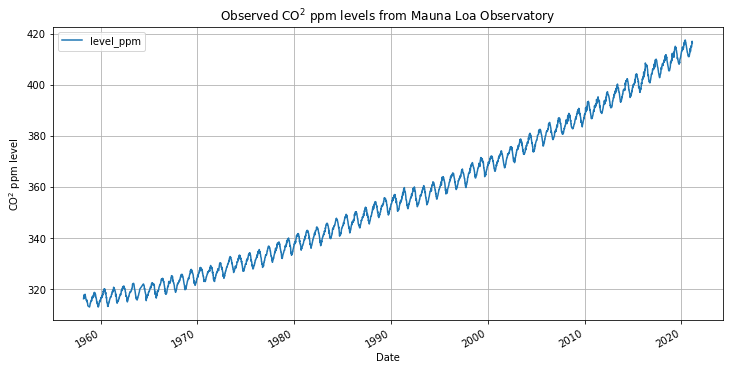

In [5]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)
plt.ylabel('CO$^2$ ppm level')
plt.xlabel('Date')
plt.title('Observed CO$^2$ ppm levels from Mauna Loa Observatory')
plt.savefig('observed_data.png')

In [6]:
df['ordinal'] = df['date'].apply(datetime.toordinal)
df.head()

,date,level_ppm,ordinal
0,1958-03-29,316.25,714867
1,1958-04-05,317.25,714874
2,1958-04-12,317.75,714881
3,1958-04-19,317.50,714888
4,1958-04-26,316.50,714895


In [7]:
bad_stan_model = pystan.StanModel(file='bad_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2111de3b1caf3c6cde595452b3450372 NOW.


In [8]:
parameters = ['c0', 'c1', 'c2', 'c3', 'sigma']
last_date = date(2060, 1, 1)
future_count = last_date.toordinal() - max(df['ordinal'])
stan_data = {
    'N': len(df),
    'y': df['level_ppm'],
    'x': df['ordinal'],
    'nFutureDays': future_count
}
bad_results = bad_stan_model.sampling(data=stan_data)
print(bad_results.stansummary(pars=parameters))
samples = bad_results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_2111de3b1caf3c6cde595452b3450372.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0     -2812    0.14   7.74  -2827  -2817  -2812  -2807  -2797   2925    1.0
c1    4.4e-3  2.0e-7 1.1e-5 4.3e-3 4.4e-3 4.4e-3 4.4e-3 4.4e-3   2921    1.0
c2      1.41    1.74   2.46  -2.96  -0.29   2.78   2.87   3.02      2  26.51
c3     -0.87    0.96   1.36  -1.72  -1.68  -1.64   0.06   1.53      2   42.0
sigma    4.0  8.5e-4   0.05    3.9   3.96    4.0   4.03    4.1   3631    1.0

Samples were drawn using NUTS at Thu Apr 22 06:16:21 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [9]:
# Model parameters
c0 = bad_results['c0'][0]
c1 = bad_results['c1'][0]
c2 = bad_results['c2'][0]
c3 = bad_results['c3'][0]

In [10]:
# Stan model future predictions output
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

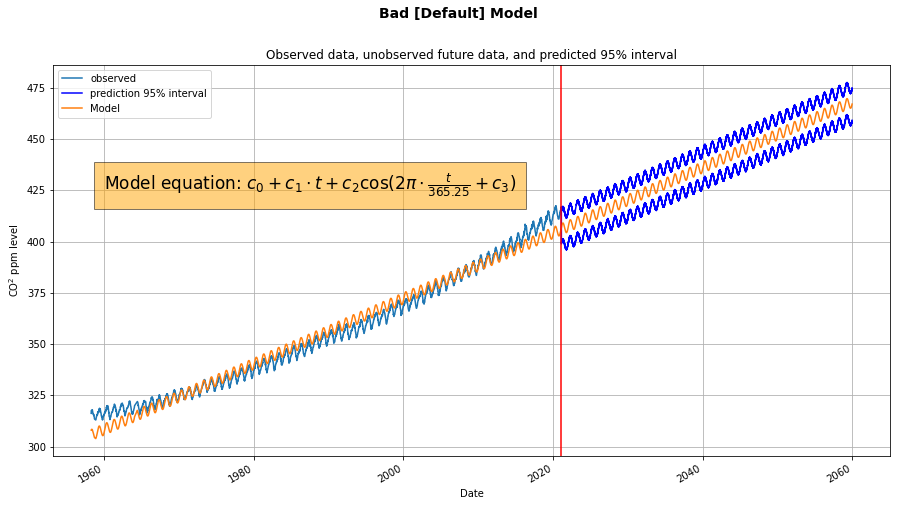

In [11]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Bad [Default] Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    pd.date_range(start=max(df['date']),end=last_date),
    np.concatenate((df['level_ppm'][-1:], prediction_interval[0,:])),
    'b-', label='prediction 95% interval')
ax.plot(
    pd.date_range(start=max(df['date']),end=last_date),
    np.concatenate((df['level_ppm'][-1:], prediction_interval[1,:])),
    'b-')

# Model
future_dates = pd.date_range(start=max(df['date']),end=last_date).to_series()
to_predict_dates = df['date'].append(future_dates)
to_predict = to_predict_dates.apply(datetime.toordinal)

model_predictions = c0 + c1* to_predict + c2 * np.cos(2 * np.pi * to_predict / 365.25 + c3)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()
ax.set_title('Observed data, unobserved future data, and predicted 95% interval')
ax.text(
    date(1960, 1, 1), 425, 
    r'Model equation: $c_0 + c_1 \cdot t + c_2 \cos(2 \pi \cdot \frac{t}{365.25} + c_3$)', 
    fontsize=17, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10}
)
plt.savefig('bad_model.png')
plt.show()